In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
class DemosaicingDataset(Dataset):
    def __init__(self, root_dir, split_file, patch_size=33, stride=33, transform=None):
        self.root_dir = root_dir
        self.groundtruth_dir = os.path.join(root_dir, 'groundtruth')
        self.input_dir = os.path.join(root_dir, 'input')
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform
        
        with open(split_file, 'r') as f:
            self.image_files = [line.strip() + '.png' for line in f.readlines()]
        print(f"Found {len(self.image_files)} images in {os.path.basename(split_file)}")
        self.patches = self._prepare_patches()
        
    def _create_cfa_channels(self, bayer_img):
        """Convert single-channel Bayer image to 3-channel representation with zeros in missing positions"""
        H, W = bayer_img.shape
        cfa = np.zeros((H, W, 3), dtype=bayer_img.dtype)
        
        # RGGB pattern
        # Red channel - R positions
        cfa[0::2, 0::2, 0] = bayer_img[0::2, 0::2]
        
        # Green channel - G positions
        cfa[0::2, 1::2, 1] = bayer_img[0::2, 1::2]  # G in red rows
        cfa[1::2, 0::2, 1] = bayer_img[1::2, 0::2]  # G in blue rows
        
        # Blue channel - B positions
        cfa[1::2, 1::2, 2] = bayer_img[1::2, 1::2]
        
        return cfa
        
    def _prepare_patches(self):
        patches = []
        for i, img_file in enumerate(self.image_files):
            print(f"Processing image {i+1}/{len(self.image_files)}", end='\r')
            
            # Load ground truth RGB image
            gt_path = os.path.join(self.groundtruth_dir, img_file)
            gt_img = cv2.imread(gt_path)
            gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
            
            # Load raw Bayer image
            input_path = os.path.join(self.input_dir, img_file)
            bayer_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            
            # Normalize images
            bayer_img = bayer_img.astype(np.float32) / 65535.0
            gt_img = gt_img.astype(np.float32) / 255.0
            
            # Convert Bayer to 3-channel representation
            input_img = self._create_cfa_channels(bayer_img)
            
            h, w = bayer_img.shape
            
            for y in range(0, h - self.patch_size + 1, self.stride):
                for x in range(0, w - self.patch_size + 1, self.stride):
                    input_patch = input_img[y:y+self.patch_size, x:x+self.patch_size]
                    gt_patch = gt_img[y:y+self.patch_size, x:x+self.patch_size]
                    
                    # Skip patches with low variance
                    if np.std(input_patch) > 0.01:
                        patches.append({
                            'input': input_patch,
                            'target': gt_patch,
                            'image_file': img_file,
                            'position': (y, x)
                        })
        
        print(f"\nExtracted {len(patches)} valid patches")
        return patches
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = self.patches[idx]
        
        # Convert to torch tensors (CxHxW format)
        input_tensor = torch.from_numpy(patch['input']).float().permute(2, 0, 1)
        target_tensor = torch.from_numpy(patch['target']).float().permute(2, 0, 1)
        
        if self.transform:
            input_tensor = self.transform(input_tensor)
            target_tensor = self.transform(target_tensor)
            
        return {
            'input': input_tensor,
            'target': target_tensor,
            'image_file': patch['image_file'],
            'position': patch['position']
        }


In [4]:
class DMCNNVD(nn.Module):
    def __init__(self):
        super(DMCNNVD, self).__init__()
        
        # Initial bilinear interpolation is done before input
        
        # 20 layers of conv + BN + SELU
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(3 if i == 0 else 64, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.SELU(inplace=True)
            ) for i in range(19)
        ])
        
        # Final layer without activation
        self.final = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        
    def forward(self, x):
        # Residual learning - save input
        residual = x
        
        # Process through layers
        out = x
        for layer in self.layers:
            out = layer(out)
            
        out = self.final(out)
        
        # Add residual connection
        return out + residual

In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for i, batch in enumerate(train_loader):
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i + 1) % 100 == 0:
            print(f'Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.6f}', end='\r')
    
    return running_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    
    return running_loss / len(val_loader)


In [6]:

# Dataset preparation
dataset_path = 'dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic'
split_files = {
    'train': os.path.join(dataset_path, 'train.txt'),
    'val': os.path.join(dataset_path, 'validation.txt'),
    'test': os.path.join(dataset_path, 'test.txt')
}

# Prepare datasets and dataloaders
datasets = {}
dataloaders = {}

for split_name, split_file in split_files.items():
    if os.path.exists(split_file):
        print(f"\nPreparing {split_name} dataset...")
        datasets[f'{split_name}_dataset'] = DemosaicingDataset(
            root_dir=dataset_path,
            split_file=split_file,
            patch_size=33,
            stride=33
        )
        dataloaders[f'{split_name}_loader'] = DataLoader(
            datasets[f'{split_name}_dataset'],
            batch_size=64,
            shuffle=(split_name == 'train'),
            num_workers=4,
            pin_memory=True
        )

# Initialize model, loss, and optimizer
model = DMCNNVD().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Training parameters
n_epochs = 250
best_val_loss = float('inf')
train_losses = []
val_losses = []

# Training loop
print("\nStarting training...")
for epoch in range(n_epochs):
    print(f'\nEpoch [{epoch+1}/{n_epochs}]')
    
    # Train
    train_loss = train_epoch(model, dataloaders['train_loader'], criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, dataloaders['val_loader'], criterion, device)
    val_losses.append(val_loss)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_demosaic_model.pth')
    
    # Print epoch results
    print(f'\nEpoch [{epoch+1}/{n_epochs}]')
    print(f'Train Loss: {train_loss:.6f}')
    print(f'Val Loss: {val_loss:.6f}')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')



Preparing train dataset...
Found 200 images in train.txt
Processing image 200/200
Extracted 4697 valid patches

Preparing val dataset...
Found 100 images in validation.txt
Processing image 100/100
Extracted 2380 valid patches

Preparing test dataset...
Found 200 images in test.txt
Processing image 200/200
Extracted 4675 valid patches

Starting training...

Epoch [1/250]

Epoch [1/250]
Train Loss: 0.041398
Val Loss: 0.012824
Learning Rate: 0.001000

Epoch [2/250]

Epoch [2/250]
Train Loss: 0.008099
Val Loss: 0.009389
Learning Rate: 0.001000

Epoch [3/250]

Epoch [3/250]
Train Loss: 0.006658
Val Loss: 0.007586
Learning Rate: 0.001000

Epoch [4/250]

Epoch [4/250]
Train Loss: 0.006135
Val Loss: 0.008947
Learning Rate: 0.001000

Epoch [5/250]

Epoch [5/250]
Train Loss: 0.004684
Val Loss: 0.004260
Learning Rate: 0.001000

Epoch [6/250]

Epoch [6/250]
Train Loss: 0.004421
Val Loss: 0.003242
Learning Rate: 0.001000

Epoch [7/250]

Epoch [7/250]
Train Loss: 0.003368
Val Loss: 0.003472
Learnin

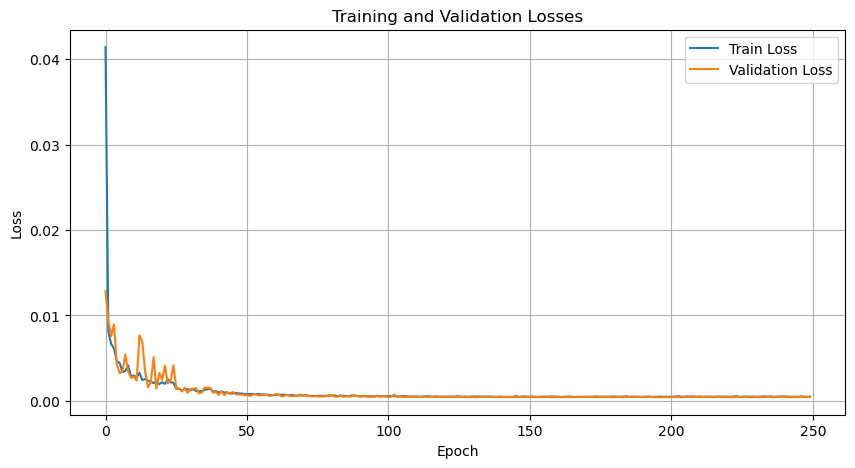

In [7]:

# Plot training results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

Visualizing full image reconstruction...


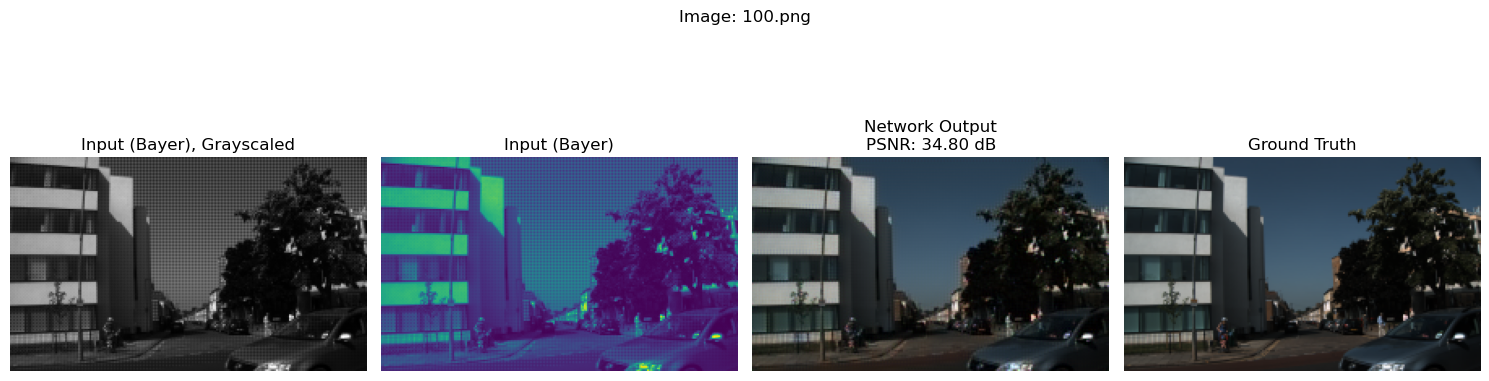

In [9]:
def reconstruct_and_visualize(model, test_loader, device):
    """Simple visualization of full image reconstruction."""
    model.eval()
    
    # Get a batch
    batch = next(iter(test_loader))
    
    # Get original image name and load full images
    img_file = batch['image_file'][0]
    
    # Load full ground truth image
    gt_path = os.path.join(test_loader.dataset.groundtruth_dir, img_file)
    gt_img = cv2.imread(gt_path)
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    gt_img = gt_img.astype(np.float32) / 255.0
    
    # Load full input image (Bayer)
    input_path = os.path.join(test_loader.dataset.input_dir, img_file)
    bayer_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    bayer_img = bayer_img.astype(np.float32) / 65535.0
    
    # Create 3-channel input
    h, w = bayer_img.shape
    input_3ch = np.zeros((h, w, 3), dtype=np.float32)
    
    # RGGB pattern
    input_3ch[0::2, 0::2, 0] = bayer_img[0::2, 0::2]  # R
    input_3ch[0::2, 1::2, 1] = bayer_img[0::2, 1::2]  # G
    input_3ch[1::2, 0::2, 1] = bayer_img[1::2, 0::2]  # G
    input_3ch[1::2, 1::2, 2] = bayer_img[1::2, 1::2]  # B
    
    # Process with network
    with torch.no_grad():
        input_tensor = torch.from_numpy(input_3ch).float().permute(2, 0, 1).unsqueeze(0).to(device)
        output = model(input_tensor)
        output_img = output[0].cpu().numpy().transpose(1, 2, 0)
    
    # Calculate PSNR
    mse = np.mean((gt_img - output_img) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))
    
    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    
    axes[0].imshow(bayer_img, cmap='gray')
    axes[0].set_title('Input (Bayer), Grayscaled')
    axes[0].axis('off')

    axes[1].imshow(bayer_img)
    axes[1].set_title('Input (Bayer)')
    axes[1].axis('off')
    
    axes[2].imshow(np.clip(output_img, 0, 1))
    axes[2].set_title(f'Network Output\nPSNR: {psnr:.2f} dB')
    axes[2].axis('off')
    
    axes[3].imshow(gt_img)
    axes[3].set_title('Ground Truth')
    axes[3].axis('off')
    
    plt.suptitle(f'Image: {img_file}')
    plt.tight_layout()
    plt.show()

# Call after training or loading a model
print("Visualizing full image reconstruction...")
reconstruct_and_visualize(model, dataloaders['test_loader'], device)